In [3]:
import pandas as pd
import itertools
import collections
import numpy as np
from tqdm import tqdm
import gensim
import re
import json
import sklearn
import matplotlib.pyplot as plt
from unidecode import unidecode
import os
from urllib.request import urlretrieve

We import a csv file with issues and lists of queries for those issues, created by experts.
We also load a fasttext word embedding model

In [4]:
filename_issues = 'data/issues-queries.csv'
filename_fasttext = 'data/fasttext-aem-amcat50.bin'
if not os.path.exists(filename_fasttext):
    urlretrieve('https://surfdrive.surf.nl/files/index.php/s/91TFDG1qsEMtX4d/download', filename_fasttext)

In [11]:
model = gensim.models.fasttext.load_facebook_model(filename_fasttext)

In [5]:
df_issues = pd.read_csv(filename_issues)
df_issues.head()

,queryIssue,directI,parentI,gparentI,parentA,gparentA,zoek1,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,aardgasbaten,pos,begrotingssaldo,issue,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ambtenarensal*,neg,begrotingssaldo,issue,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,begrotingsdiscipline,pos,begrotingssaldo,issue,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,begrotingsnorm,pos,begrotingssaldo,issue,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,begrotingsoverschot,pos,begrotingssaldo,issue,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We are only interested in the `queryIssue` column and `parentI` column. `dircetI` might be interesting in the future because it tells something about directionality, but we ignore it for now.

We need to do some cleaning up: there's a spelling mistake for one issue.

In [6]:
df_issues.loc[df_issues.parentI=='infrastructuur', 'parentI'] = 'Infrastructuur'

These are the number of queries per issue:

In [7]:
df_issues.parentI.value_counts()

klimaatMilieu          112
ondernemingsklimaat     71
Infrastructuur          70
ontwikkelingCrim        66
coronabestrijding       65
OenW                    65
geZorg                  61
socZek                  56
belastHeffing           53
bestrijdingCrim         45
integratie              35
vrijheidsrechten        29
werk                    25
coronaverspreiding      25
EuropeseUnie            24
normenWaarden           22
begrotingssaldo         20
woning                  18
terreurbestrijding      14
bestVernieuw            13
ontwikHulp              12
Name: parentI, dtype: int64

In [8]:
def preprocess_word(s, drop_asterix=False):
    if drop_asterix:
        reg = re.compile(r'[^a-zA-Z\. ]')
    else:
        reg = re.compile(r'[^a-zA-Z\. \*]')
    
    s = unidecode(s)
    s = reg.sub('', s)
    s = s.lower().strip()
    return s

In [9]:
issues_dict = df_issues.groupby('parentI')['queryIssue'].agg(list).to_dict()

## Expand queries with wild cards
Some query words contain asterices for pattern matching. We expand the query set to include all words from the embedding vocabulary that match the pattenrs

In [12]:
# Retrieve vocabulary of embedding model
vocab = model.wv.vocab.keys()
len(vocab)

1143658

In [10]:
issues_dict_expanded = collections.defaultdict(list)

for issue, query_list in issues_dict.items():
    print(issue)
    for query_term in query_list:
        if '*' in query_term:
            query_preprocessed = preprocess_word(query_term).replace('*', '.*')
            query_regex = re.compile(query_preprocessed)
            new_queries = [(v, 'expanded') for v in vocab if query_regex.fullmatch(v) ]
            issues_dict_expanded[issue].extend(new_queries)
            issues_dict_expanded[issue].append((query_term, 'wildcard'))
        else:
            issues_dict_expanded[issue].append((query_term, 'original'))

EuropeseUnie
Infrastructuur
OenW
begrotingssaldo
belastHeffing
bestVernieuw
bestrijdingCrim
coronabestrijding
coronaverspreiding
geZorg
integratie
klimaatMilieu
normenWaarden
ondernemingsklimaat
ontwikHulp
ontwikkelingCrim
socZek
terreurbestrijding
vrijheidsrechten
werk
woning


In [11]:
# And put them in a dataframe
issues_expanded_df = pd.DataFrame([(query, issue, category) for issue, query_list in issues_dict_expanded.items() for (query, category) in query_list],
             columns=('query', 'issue', 'category'))
issues_expanded_df['query_preprocessed'] = [preprocess_word(s, drop_asterix=True) for s in issues_expanded_df['query']]
issues_expanded_df.head()

,query,issue,category,query_preprocessed
0,3 procent,EuropeseUnie,original,procent
1,60 procent,EuropeseUnie,original,procent
2,brexit,EuropeseUnie,original,brexit
3,coronaherstelfonds,EuropeseUnie,original,coronaherstelfonds
4,ECB,EuropeseUnie,original,ecb


Let's have a look at the number of queries in the original set (not containing a wildcard), the number of wildcard queries and the number of queries that result from the expansion.

Note that the expansion leads to a much bigger set than the original query set!preprocess_word

In [12]:
issues_expanded_df.groupby(['issue', 'category'])['query'].count().unstack()

category,expanded,original,wildcard
issue,,,
EuropeseUnie,12,21,3
Infrastructuur,5056,39,31
OenW,3766,31,34
begrotingssaldo,206,15,5
belastHeffing,504,41,12
bestVernieuw,87,11,2
bestrijdingCrim,604,32,13
coronabestrijding,583,40,25
coronaverspreiding,389,18,7


We also check for each of the queries, whether the query exists in the fasttext vocabulary. For wildcard queries, we remove the asterix and see if the remaining string exists.
Note that some queries consist of multiple words, these will not be found in the vocabulary.

In [13]:
in_vocab_list = []
for _, (query, issue, category, query_preprocessed) in issues_expanded_df.iterrows():
    in_vocab = query_preprocessed in vocab
    in_vocab_list.append(in_vocab)

issues_expanded_df['vocab'] = in_vocab_list

How many of the words can be found in the vocabulary?

In [14]:
counts_per_cat = issues_expanded_df.groupby(['category', 'vocab'])['query'].count().unstack().fillna(0)
counts_per_cat['percentage'] = counts_per_cat[True] / (counts_per_cat[False]+counts_per_cat[True])
counts_per_cat

vocab,False,True,percentage
category,,,
expanded,0.0,27834.0,1.000000
original,68.0,477.0,0.875229
wildcard,83.0,273.0,0.766854


And plot the number of query terms (without the expansion) for each issue. Note that some issues, like EuropeseUnie and ontwikHulp have very few query words with many out-of-vocabulary.

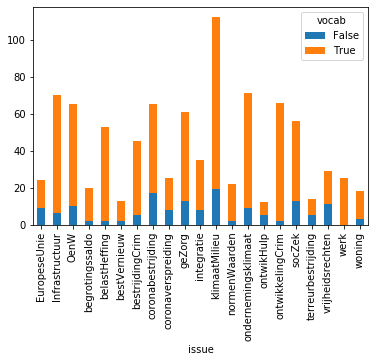

In [15]:
issues_expanded_df[issues_expanded_df.category!='expanded'].groupby(['issue', 'vocab'])['query'].count().unstack().plot(kind='bar', stacked=True)

There's also some query words that are present in multiple issues

In [16]:
query_counts = issues_expanded_df['query'].value_counts()
double_queries = query_counts[query_counts>1].index
double_queries = issues_expanded_df[issues_expanded_df['query'].isin(double_queries)]
double_queries

,query,issue,category,query_preprocessed,vocab
32,medicijnagentschap,EuropeseUnie,original,medicijnagentschap,True
290,filebelasting,Infrastructuur,expanded,filebelasting,True
809,havenbelasting,Infrastructuur,expanded,havenbelasting,True
1181,parkeerbelasting,Infrastructuur,expanded,parkeerbelasting,True
3401,transportbelasting,Infrastructuur,expanded,transportbelasting,True
...,...,...,...,...,...
28225,arbeidertje,werk,expanded,arbeidertje,True
28226,arbeiderstuinen,werk,expanded,arbeiderstuinen,True
28228,arbeidsuren,werk,original,arbeidsuren,True
28524,werknemersverzekeringen,werk,expanded,werknemersverzekeringen,True


Most result from the expanded query sets, if we look at the non-expanded queries there is no overlap:

In [17]:
double_queries[double_queries['category']!='expanded'].sort_values('query')

,query,issue,category,query_preprocessed,vocab
28228,arbeidsuren,werk,original,arbeidsuren,True
9671,belasting,belastHeffing,original,belasting,True
26760,discriminatieverbod,vrijheidsrechten,original,discriminatieverbod,True
9711,dividendbelasting,belastHeffing,original,dividendbelasting,True
9718,inkomensbelasting,belastHeffing,original,inkomensbelasting,True
9723,loonbelasting,belastHeffing,original,loonbelasting,True
32,medicijnagentschap,EuropeseUnie,original,medicijnagentschap,True
19706,omzetverlies,ondernemingsklimaat,original,omzetverlies,True
19873,ondernemingsklimaat,ondernemingsklimaat,original,ondernemingsklimaat,True
13301,patient,geZorg,original,patient,True


In [18]:
double_queries_lists = double_queries.groupby(['query'])['issue'].agg(list)
multiple_queries = pd.DataFrame(double_queries_lists.to_list(), columns=['issue1', 'issue2'], index=double_queries_lists.index)

In [19]:
# Compare which issues often have overlap
multiple_queries.reset_index().groupby(['issue1', 'issue2']).count().unstack()

query                                         \
issue2              belastHeffing coronabestrijding geZorg klimaatMilieu   
issue1                                                                     
EuropeseUnie                  NaN               NaN    1.0           NaN   
Infrastructuur                6.0               NaN    NaN           NaN   
OenW                          2.0               NaN    NaN           NaN   
belastHeffing                 6.0               NaN    2.0           1.0   
coronabestrijding             NaN               1.0    NaN           NaN   
coronaverspreiding            NaN               NaN    1.0           NaN   
geZorg                        NaN               NaN    NaN           NaN   
integratie                    NaN               NaN    NaN           NaN   
normenWaarden                 NaN               NaN    NaN           NaN   
ondernemingsklimaat           NaN               NaN    NaN           NaN   
ontwikkelingCrim              NaN               NaN    NaN           NaN   
socZek                        NaN               NaN    NaN           NaN   
vrijheidsrechten              NaN               NaN    NaN           NaN   
werk                          NaN               NaN    NaN           NaN   

                                                                               \
issue2              normenWaarden ondernemingsklimaat ontwikkelingCrim socZek   
issue1                                                                          
EuropeseUnie                  NaN                 NaN              NaN    NaN   
Infrastructuur                NaN                 NaN              NaN    NaN   
OenW                          NaN                 NaN              NaN    NaN   
belastHeffing                 NaN                 6.0              NaN    1.0   
coronabestrijding             NaN                 NaN              NaN    NaN   
coronaverspreiding            NaN                 NaN              NaN    NaN   
geZorg                        NaN                 7.0              NaN    1.0   
integratie                    8.0                 NaN              NaN    NaN   
normenWaarden                 NaN                 NaN              NaN    NaN   
ondernemingsklimaat           NaN                 2.0              NaN    NaN   
ontwikkelingCrim              NaN                 NaN              5.0  213.0   
socZek                        NaN                 NaN              NaN    NaN   
vrijheidsrechten              NaN                 NaN              NaN    NaN   
werk                          NaN                 NaN              NaN    NaN   

                                                                
issue2              terreurbestrijding vrijheidsrechten   werk  
issue1                                                          
EuropeseUnie                       NaN              NaN    NaN  
Infrastructuur                     NaN              NaN    NaN  
OenW                               NaN              3.0    NaN  
belastHeffing                      1.0              NaN    1.0  
coronabestrijding                  NaN              NaN    NaN  
coronaverspreiding                 NaN              NaN    NaN  
geZorg                             NaN              NaN    NaN  
integratie                         2.0              1.0    NaN  
normenWaarden                      NaN              1.0    NaN  
ondernemingsklimaat                NaN              2.0    NaN  
ontwikkelingCrim                   NaN              NaN    NaN  
socZek                             NaN              1.0  167.0  
vrijheidsrechten                   NaN              1.0    NaN  
werk                               NaN              NaN    1.0

## Write a file with the query terms

In [20]:
issues_expanded_df.to_csv('data/queries-asterix-expanded.csv', index=False)

In [21]:
print(model.wv['derde wereld'])
print(model.wv['derde'] + model.wv['wereld'])

[-0.46345964  0.25302714 -0.23467009 -0.3212895  -0.1197774  -0.27843386
  0.2528233   0.33738562 -0.03202897 -0.39693046 -0.01489466 -0.02395553
 -0.08142199  0.5715131   0.02786961  0.04377398 -0.28492305 -0.3780888
 -0.01339517 -0.15187648  0.4044422  -0.06428899  0.45362082  0.69295275
  0.20050603  0.36262748 -0.0262194  -0.2532986  -0.06246025 -0.43589216
  0.2479171  -0.39653286 -0.10269102  0.00280987 -0.22290108 -0.47799993
  0.13383141 -0.34703296  0.05066733  0.26545238 -0.29297608  0.072221
  0.211784   -0.25528678 -0.18635    -0.25736728 -0.24096334  0.5897406
 -0.12329546  0.08449508]
[-0.40671507  0.44521353 -0.56057525 -0.30436102 -0.2506741  -0.21666573
  0.2012085   0.07161587  0.65419364 -0.48055503 -0.7711575   0.13317567
  0.77656    -0.15083064 -0.00536054  0.10098314 -0.7154036  -0.39548874
 -0.05324354 -0.27036047  0.56969565 -1.1427689   0.65421057  1.0965416
  0.9245841  -0.11234487  0.56764776  0.01789492 -1.3709974  -0.5843805
 -0.3887163  -0.8844489  -0.471

In [22]:
w1 = 'derde'
w2 = 'wereld'
v1 = model.wv[w1]+model.wv[w2]
v2 = model.wv[w1 + ' ' + w2]
model.wv.cosine_similarities(gensim.matutils.unitvec(v1), 
                             [v2])

array([0.5268506], dtype=float32)